In [1]:
# Setup
import pandas as pd
import numpy as np
import git
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.transforms as T

import matplotlib.pyplot as plt
%matplotlib inline

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir
dtype=torch.float32

from barebone import *
from model_util import *

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

/opt/conda/envs/posedemo/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Precalculated Features

In [2]:
# Create a numpy array containing all the calculated features Poseformer (HRNet output)
# Exclude fields 0 (identifiers), 1 (number of cycles, duplicate), 2 (orientation), 3 (framerate)
df_calc = pd.read_csv(r'https://raw.githubusercontent.com/amandaliusa/cs231n/main/results/results-poseformer-2023-06-04.csv')
df_calc.drop(['Unnamed: 0', 'n', 'orientation', 'framerate'], axis=1, inplace=True)
df_calc

,subjectid,time,time_diff,speed,time_sd,speed_sd,n_sit2stand,time_sit2stand,time_diff_sit2stand,speed_sit2stand,...,neck_max_y_acc_stand2sit,ank_to_hip_dist_sit,ank_to_hip_dist_stand,knee_to_hip_dist_sit,knee_to_hip_dist_stand,height,lknee_angle_first_sit,rknee_angle_first_sit,lknee_angle_first_stand,rknee_angle_first_stand
0,kEC7G8DP,11.666667,0.391667,0.43,0.568429,0.109845,5,5.000000,-0.083333,1.00,...,28.745159,1.592739,3.180187,1.704116,2.036679,0.915840,126.157028,163.349759,193.017009,163.114972
1,GjPHiGli,14.033333,-0.066667,0.36,0.247117,0.030709,5,5.266667,-0.791667,0.95,...,15.500082,1.627585,1.900191,1.513419,1.420853,0.918023,111.429866,128.344066,178.385573,180.138872
2,RFibHPt7,13.833333,-0.241667,0.36,0.374166,0.059231,5,4.333333,-1.166667,1.15,...,18.362819,1.376164,1.563910,1.026070,1.518753,0.971309,96.485192,94.164582,168.988900,177.376363
3,gO7Cpt1X,11.500000,0.283333,0.43,0.733333,0.190154,5,3.900000,-0.866667,1.28,...,9.234772,1.296188,1.158777,1.313558,1.067322,0.925391,102.517993,113.330788,181.267085,214.777400
4,xEIsrkiR,12.266667,-0.500000,0.41,0.972420,0.342664,5,2.233333,-2.000000,2.24,...,30.753857,0.986963,1.307289,0.568683,0.639755,0.970054,151.456744,138.360954,201.445506,178.812067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,VID_20230506_175810340,15.366667,-0.511111,0.26,0.682469,0.058440,4,5.966667,-1.311111,0.67,...,19.173748,0.831932,1.170661,0.644232,1.117247,0.956355,131.244122,104.038109,173.939678,191.231743
380,8elUiJYv,7.400000,0.108333,0.68,0.209338,0.106825,5,4.000000,0.100000,1.25,...,28.401683,7.196703,0.972598,3.195569,2.493561,0.954803,108.555146,147.880615,130.857804,188.354355
381,PXL_20230505_234002299,14.300000,-0.544444,0.28,0.718554,0.077061,4,4.900000,-1.655556,0.82,...,14.930358,0.760820,0.755019,0.969426,1.280454,0.941937,100.971541,108.121823,173.023627,204.930390
382,q8FyLMSn,6.400000,0.000000,0.78,0.068638,0.042368,5,3.633333,0.175000,1.38,...,29.172789,1.067852,1.971949,1.831015,2.785638,0.920683,111.605142,178.523509,146.016761,189.715575


### Load Survey Data (labels)

In [3]:
df_survey = pd.read_csv(r'https://raw.githubusercontent.com/amandaliusa/cs231n/main/data/survey_data.csv')
df_survey

,subjectid,OA_check
0,kGhQ1FQc,1
1,KyINSk8e,0
2,ybGzWMPA,0
3,b632WDpF,0
4,UDXlpEgF,0
...,...,...
400,tFSyXitq,1
401,OuYG4U64,0
402,nM7tQcBS,0
403,zN0O4jLu,0


### Preprocessing 

- Create train/val/test sets
- Normalization
- Oversampling
- Hand-pick features

In [4]:
# join the dataframes by subjectId 
df_join = df_calc.set_index('subjectid').join(df_survey.set_index('subjectid')).astype('float32')
df_join

,time,time_diff,speed,time_sd,speed_sd,n_sit2stand,time_sit2stand,time_diff_sit2stand,speed_sit2stand,time_sd_sit2stand,...,ank_to_hip_dist_sit,ank_to_hip_dist_stand,knee_to_hip_dist_sit,knee_to_hip_dist_stand,height,lknee_angle_first_sit,rknee_angle_first_sit,lknee_angle_first_stand,rknee_angle_first_stand,OA_check
subjectid,,,,,,,,,,,,,,,,,,,,,
kEC7G8DP,11.666667,0.391667,0.43,0.568429,0.109845,5.0,5.000000,-0.083333,1.00,0.164655,...,1.592739,3.180187,1.704116,2.036679,0.915840,126.157028,163.349762,193.017014,163.114975,0.0
GjPHiGli,14.033334,-0.066667,0.36,0.247117,0.030709,5.0,5.266667,-0.791667,0.95,0.203961,...,1.627585,1.900191,1.513419,1.420853,0.918023,111.429863,128.344070,178.385574,180.138870,0.0
RFibHPt7,13.833333,-0.241667,0.36,0.374166,0.059231,5.0,4.333333,-1.166667,1.15,0.180123,...,1.376164,1.563910,1.026070,1.518753,0.971309,96.485191,94.164581,168.988907,177.376358,0.0
gO7Cpt1X,11.500000,0.283333,0.43,0.733333,0.190154,5.0,3.900000,-0.866667,1.28,0.381576,...,1.296188,1.158777,1.313558,1.067322,0.925391,102.517990,113.330788,181.267090,214.777405,0.0
xEIsrkiR,12.266666,-0.500000,0.41,0.972420,0.342664,5.0,2.233333,-2.000000,2.24,0.149963,...,0.986963,1.307289,0.568683,0.639755,0.970054,151.456741,138.360947,201.445511,178.812073,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VID_20230506_175810340,15.366667,-0.511111,0.26,0.682469,0.058440,4.0,5.966667,-1.311111,0.67,0.189113,...,0.831932,1.170661,0.644232,1.117247,0.956355,131.244125,104.038109,173.939682,191.231750,NaN
8elUiJYv,7.400000,0.108333,0.68,0.209338,0.106825,5.0,4.000000,0.100000,1.25,0.172562,...,7.196703,0.972598,3.195569,2.493561,0.954803,108.555145,147.880615,130.857803,188.354355,0.0
PXL_20230505_234002299,14.300000,-0.544444,0.28,0.718554,0.077061,4.0,4.900000,-1.655556,0.82,0.317433,...,0.760820,0.755019,0.969426,1.280454,0.941937,100.971542,108.121826,173.023621,204.930389,NaN


In [5]:
# all videos from the new clinical trial have OA=1 
df_join = df_join.fillna(value={'OA_check': 1})
df_join

,time,time_diff,speed,time_sd,speed_sd,n_sit2stand,time_sit2stand,time_diff_sit2stand,speed_sit2stand,time_sd_sit2stand,...,ank_to_hip_dist_sit,ank_to_hip_dist_stand,knee_to_hip_dist_sit,knee_to_hip_dist_stand,height,lknee_angle_first_sit,rknee_angle_first_sit,lknee_angle_first_stand,rknee_angle_first_stand,OA_check
subjectid,,,,,,,,,,,,,,,,,,,,,
kEC7G8DP,11.666667,0.391667,0.43,0.568429,0.109845,5.0,5.000000,-0.083333,1.00,0.164655,...,1.592739,3.180187,1.704116,2.036679,0.915840,126.157028,163.349762,193.017014,163.114975,0.0
GjPHiGli,14.033334,-0.066667,0.36,0.247117,0.030709,5.0,5.266667,-0.791667,0.95,0.203961,...,1.627585,1.900191,1.513419,1.420853,0.918023,111.429863,128.344070,178.385574,180.138870,0.0
RFibHPt7,13.833333,-0.241667,0.36,0.374166,0.059231,5.0,4.333333,-1.166667,1.15,0.180123,...,1.376164,1.563910,1.026070,1.518753,0.971309,96.485191,94.164581,168.988907,177.376358,0.0
gO7Cpt1X,11.500000,0.283333,0.43,0.733333,0.190154,5.0,3.900000,-0.866667,1.28,0.381576,...,1.296188,1.158777,1.313558,1.067322,0.925391,102.517990,113.330788,181.267090,214.777405,0.0
xEIsrkiR,12.266666,-0.500000,0.41,0.972420,0.342664,5.0,2.233333,-2.000000,2.24,0.149963,...,0.986963,1.307289,0.568683,0.639755,0.970054,151.456741,138.360947,201.445511,178.812073,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VID_20230506_175810340,15.366667,-0.511111,0.26,0.682469,0.058440,4.0,5.966667,-1.311111,0.67,0.189113,...,0.831932,1.170661,0.644232,1.117247,0.956355,131.244125,104.038109,173.939682,191.231750,1.0
8elUiJYv,7.400000,0.108333,0.68,0.209338,0.106825,5.0,4.000000,0.100000,1.25,0.172562,...,7.196703,0.972598,3.195569,2.493561,0.954803,108.555145,147.880615,130.857803,188.354355,0.0
PXL_20230505_234002299,14.300000,-0.544444,0.28,0.718554,0.077061,4.0,4.900000,-1.655556,0.82,0.317433,...,0.760820,0.755019,0.969426,1.280454,0.941937,100.971542,108.121826,173.023621,204.930389,1.0


#### Data validation 

In [6]:
# do a stratified split so that each dataset has the same proportion of OA=0 and OA=1
y = df_join['OA_check']

# set a random seed for reproducibility 
np.random.seed(42)

# split out test set from train/val
train_val_indices, test_indices = train_test_split(np.arange(len(df_join)), test_size=0.1, stratify=y)

# split out val set from train
train_ind, val_ind = train_test_split(np.arange(len(train_val_indices)), test_size=0.11111, stratify=y[train_val_indices])
train_indices = train_val_indices[train_ind]
val_indices = train_val_indices[val_ind]

In [7]:
# 384 examples 
NUM_TRAIN = len(train_indices)
NUM_VAL = len(val_indices)

train_data = df_join.iloc[train_indices]
val_data = df_join.iloc[val_indices]
test_data = df_join.iloc[test_indices]

In [8]:
# Check for number of OA positive and number of samples in the dataset
# Total - 78% OA=0, 22% OA=1
print(df_join.iloc[:,-1].count())  # 384
print(df_join.iloc[:,-1].sum())    # 84
class_counts = [df_join.iloc[:,-1].count() - df_join.iloc[:,-1].sum(), df_join.iloc[:,-1].sum()]

# Train set - This implies that if the model always predicts 0, it would have 78% training accuracy
print(train_data.iloc[:,-1].count())  # 306
print(train_data.iloc[:,-1].sum())    # 67

# Validation set - This implies that if the model always predicts 0, it would have 79% val accuracy
print(val_data.iloc[:,-1].count())  # 39
print(val_data.iloc[:,-1].sum())    # 8

# Test set - This implies that if the model always predicts 0, it would have 77% test accuracy
print(test_data.iloc[:,-1].count())  # 39
print(test_data.iloc[:,-1].sum())    # 9

384
84.0
306
67.0
39
8.0
39
9.0


#### Normalization

In [9]:
# compute mean and std of the features 
means = []
stds = []
for column in train_data.iloc[:,:-1]: # only use training set, and exclude last column, which has labels
    column_np = train_data[column].to_numpy()
    means.append(np.mean(column_np))
    stds.append(np.std(column_np))
    
# apply normalization
def transform(feature): 
    return (feature - means) / stds

#### Create dataloaders

In [10]:
# with normalization, no oversampling
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

In [11]:
for i, (data, labels) in enumerate(loader_train):
  print(data.shape, labels.shape)
  print(data,labels)
  break

torch.Size([64, 448]) torch.Size([64])
tensor([[ 0.2425,  0.2000, -0.3871,  ..., -0.8812,  0.2848,  0.1290],
        [ 1.0146, -1.2444, -0.8626,  ..., -0.0380,  0.8146, -0.0102],
        [-0.1844,  1.6137, -0.0305,  ...,  5.6187, -0.5614,  0.1678],
        ...,
        [-0.9110,  0.3332,  0.1478,  ..., -0.4158,  0.5726, -5.8664],
        [-0.0572,  0.1079, -0.1494,  ..., -0.6471,  1.3281,  0.4230],
        [-1.1290,  0.0771,  1.3365,  ..., -0.7807,  0.3857, -0.0729]]) tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0.])


#### Create a manually curated data set

In [12]:
df_join["time_sit2stand"]
potential_cols = df_join.filter(regex=(".*(time|speed|trunk).*")).columns.values
# for p in potential_cols:
#     print(p)
cols_manual = ['time_sit2stand',
'speed_sit2stand',
'time_sd_sit2stand',
'speed_sd_sit2stand',
'time_stand2sit',
'speed_stand2sit',
'time_sd_stand2sit',
'speed_sd_stand2sit',
'trunk_lean_range_mean',
'trunk_lean_sd',
'trunk_lean_max',
'trunk_lean_min',
'trunk_lean_ang_vel',
'trunk_lean_ang_acc',
'trunk_lean_max_ang_vel',
'trunk_lean_max_ang_acc',
'trunk_lean_min_ang_vel',
'trunk_lean_min_ang_acc',
'trunk_lean_range_mean_sit2stand',
'trunk_lean_sd_sit2stand',
'trunk_lean_max_sit2stand',
'trunk_lean_min_sit2stand',
'trunk_lean_ang_vel_sit2stand',
'trunk_lean_ang_acc_sit2stand',
'trunk_lean_max_ang_vel_sit2stand',
'trunk_lean_max_ang_acc_sit2stand',
'trunk_lean_min_ang_vel_sit2stand',
'trunk_lean_min_ang_acc_sit2stand',
'trunk_lean_range_mean_stand2sit',
'trunk_lean_sd_stand2sit',
'trunk_lean_max_stand2sit',
'trunk_lean_min_stand2sit',
'trunk_lean_ang_vel_stand2sit',
'trunk_lean_ang_acc_stand2sit',
'trunk_lean_max_ang_vel_stand2sit',
'trunk_lean_max_ang_acc_stand2sit',
'trunk_lean_min_ang_vel_stand2sit',
'trunk_lean_min_ang_acc_stand2sit',
'OA_check']
df_manual = df_join.loc[:,cols_manual]

In [13]:
# Create separate loader with manually selected columns

train_m = CustomDataset(dataframe=df_manual.iloc[:NUM_TRAIN+NUM_VAL])
loader_train_m = DataLoader(train_m, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val_m = CustomDataset(dataframe=df_manual.iloc[:NUM_TRAIN+NUM_VAL])
loader_val_m = DataLoader(val_m, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TRAIN+NUM_VAL)))

test_m = CustomDataset(dataframe=df_manual.iloc[NUM_TRAIN+NUM_VAL:])
loader_test_m = DataLoader(test_m, batch_size=64)

#### Create dataloaders with upsampling 

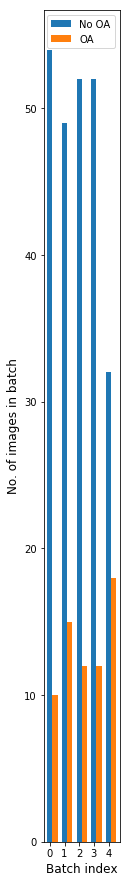

Avg Proportion of No OA per batch: 4.779999999999999
Avg Proportion of OA per batch: 1.34
Num. unique images seen: 207/306


In [14]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# visualize training data imbalance
_, _, _ = visualise_dataloader(loader_train, {0: "No OA", 1: "OA"})

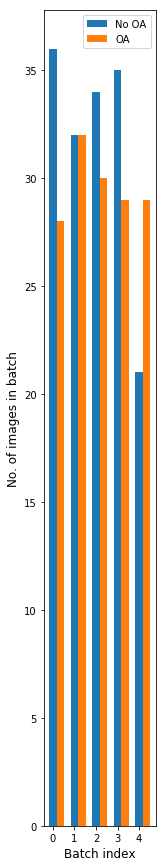

Avg Proportion of No OA per batch: 3.16
Avg Proportion of OA per batch: 2.96
Num. unique images seen: 134/306


In [15]:
train = CustomDataset(dataframe=train_data, transform=transform)
class_weights = 1./torch.tensor(class_counts, dtype=torch.float) 
labels = train_data.iloc[:,-1]
class_weights_all = class_weights[labels]

# oversample the training data 
weighted_sampler = sampler.WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

_, _, _ = visualise_dataloader(loader_train_os, {0: "No OA", 1: "OA"})

### BareBones Model

#### Train model with normalized inputs, no oversampling

In [16]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 448
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=20)

Epoch 0, loss = 0.6874, train_acc = 77.4510, val_acc = 79.4872, train_pos = 2.6144, val_pos = 0.0000
Epoch 1, loss = 0.6370, train_acc = 79.7386, val_acc = 79.4872, train_pos = 1.6340, val_pos = 0.0000
Epoch 2, loss = 0.5887, train_acc = 80.0654, val_acc = 79.4872, train_pos = 1.9608, val_pos = 0.0000
Epoch 3, loss = 0.5438, train_acc = 80.7190, val_acc = 76.9231, train_pos = 2.6144, val_pos = 2.5641
Epoch 4, loss = 0.5483, train_acc = 80.7190, val_acc = 76.9231, train_pos = 2.6144, val_pos = 2.5641
Epoch 5, loss = 0.5104, train_acc = 80.3922, val_acc = 76.9231, train_pos = 2.9412, val_pos = 2.5641
Epoch 6, loss = 0.5199, train_acc = 80.3922, val_acc = 76.9231, train_pos = 2.9412, val_pos = 2.5641
Epoch 7, loss = 0.5467, train_acc = 81.0458, val_acc = 76.9231, train_pos = 2.9412, val_pos = 2.5641
Epoch 8, loss = 0.4811, train_acc = 81.3725, val_acc = 76.9231, train_pos = 3.2680, val_pos = 2.5641
Epoch 9, loss = 0.4592, train_acc = 81.3725, val_acc = 76.9231, train_pos = 3.2680, val_pos

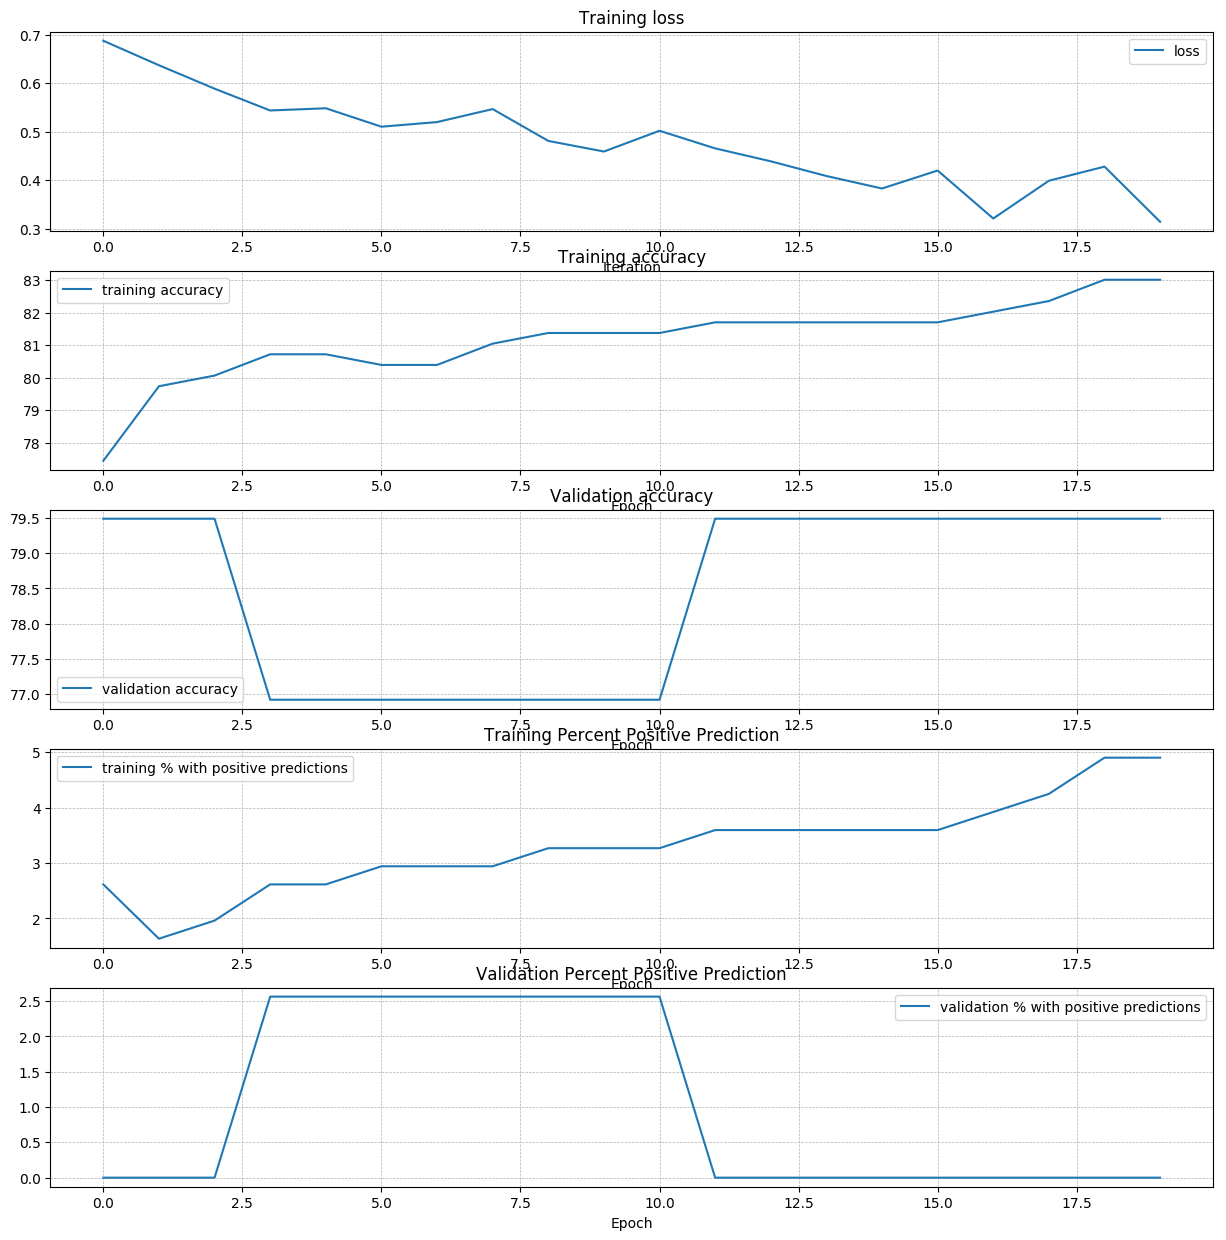

In [17]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with normalized inputs on oversampled training set

In [18]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 448
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_os, loader_val, epochs=50)

Epoch 0, loss = 0.6787, train_acc = 52.9412, val_acc = 76.9231, train_pos = 3.2680, val_pos = 7.6923
Epoch 1, loss = 0.6429, train_acc = 58.1699, val_acc = 79.4872, train_pos = 6.5359, val_pos = 10.2564
Epoch 2, loss = 0.6719, train_acc = 61.4379, val_acc = 79.4872, train_pos = 9.1503, val_pos = 10.2564
Epoch 3, loss = 0.5523, train_acc = 62.4183, val_acc = 79.4872, train_pos = 10.4575, val_pos = 10.2564
Epoch 4, loss = 0.5905, train_acc = 63.0719, val_acc = 84.6154, train_pos = 14.3791, val_pos = 10.2564
Epoch 5, loss = 0.5289, train_acc = 71.5686, val_acc = 84.6154, train_pos = 21.2418, val_pos = 10.2564
Epoch 6, loss = 0.6002, train_acc = 68.3007, val_acc = 76.9231, train_pos = 24.5098, val_pos = 17.9487
Epoch 7, loss = 0.5155, train_acc = 72.2222, val_acc = 79.4872, train_pos = 32.0261, val_pos = 20.5128
Epoch 8, loss = 0.4864, train_acc = 79.0850, val_acc = 82.0513, train_pos = 31.6993, val_pos = 23.0769
Epoch 9, loss = 0.4988, train_acc = 76.4706, val_acc = 82.0513, train_pos = 3

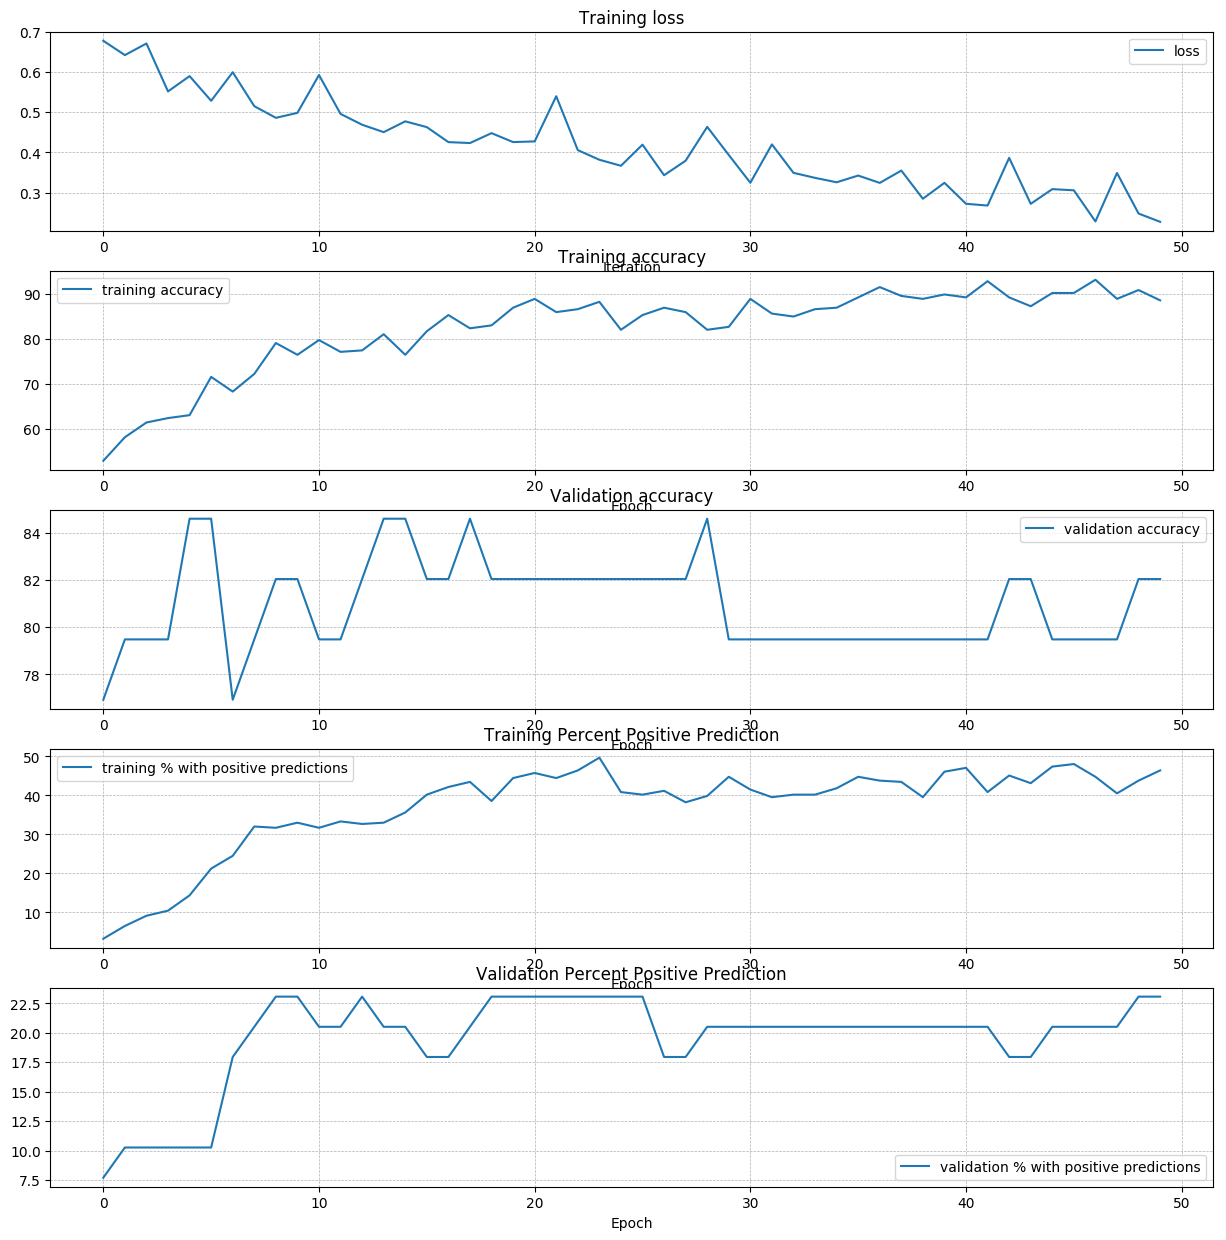

In [19]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with normalized inputs, alternative oversampling 

In [20]:
# oversample the train/val data by increasing number of OA=1 and increasing overall dataset size
#train_val_data = pd.concat([train_data, val_data], axis=0)
index_0 = train_data.index[train_data['OA_check'] == 0.0].tolist()
class_0 = train_data.loc[index_0]
index_1 = train_data.index[train_data['OA_check'] == 1.0].tolist()
class_1 = train_data.loc[index_1]
class_count_0 = len(class_0)
class_1_over = class_1.sample(class_count_0, replace=True)
train_over = pd.concat([class_1_over, class_0], axis=0)
# shuffle the DataFrame rows
train_over = train_over.sample(frac = 1)

NUM_TRAIN_OS = len(train_over)

train = CustomDataset(dataframe=train_over, transform=transform)
loader_train_os2 = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN_OS)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 448
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_os2, loader_val, epochs=50)

Epoch 0, loss = 0.6455, train_acc = 51.0460, val_acc = 79.4872, train_pos = 1.0460, val_pos = 0.0000
Epoch 1, loss = 0.6327, train_acc = 53.9749, val_acc = 79.4872, train_pos = 3.9749, val_pos = 0.0000
Epoch 2, loss = 0.5646, train_acc = 61.7155, val_acc = 87.1795, train_pos = 12.5523, val_pos = 7.6923
Epoch 3, loss = 0.5295, train_acc = 71.3389, val_acc = 87.1795, train_pos = 24.2678, val_pos = 7.6923
Epoch 4, loss = 0.4868, train_acc = 77.1967, val_acc = 84.6154, train_pos = 31.3808, val_pos = 10.2564
Epoch 5, loss = 0.5651, train_acc = 78.2427, val_acc = 87.1795, train_pos = 33.2636, val_pos = 12.8205
Epoch 6, loss = 0.4571, train_acc = 82.4268, val_acc = 87.1795, train_pos = 37.8661, val_pos = 12.8205
Epoch 7, loss = 0.5912, train_acc = 84.3096, val_acc = 82.0513, train_pos = 39.3305, val_pos = 17.9487
Epoch 8, loss = 0.4842, train_acc = 83.2636, val_acc = 82.0513, train_pos = 37.8661, val_pos = 17.9487
Epoch 9, loss = 0.4675, train_acc = 83.8912, val_acc = 87.1795, train_pos = 37.

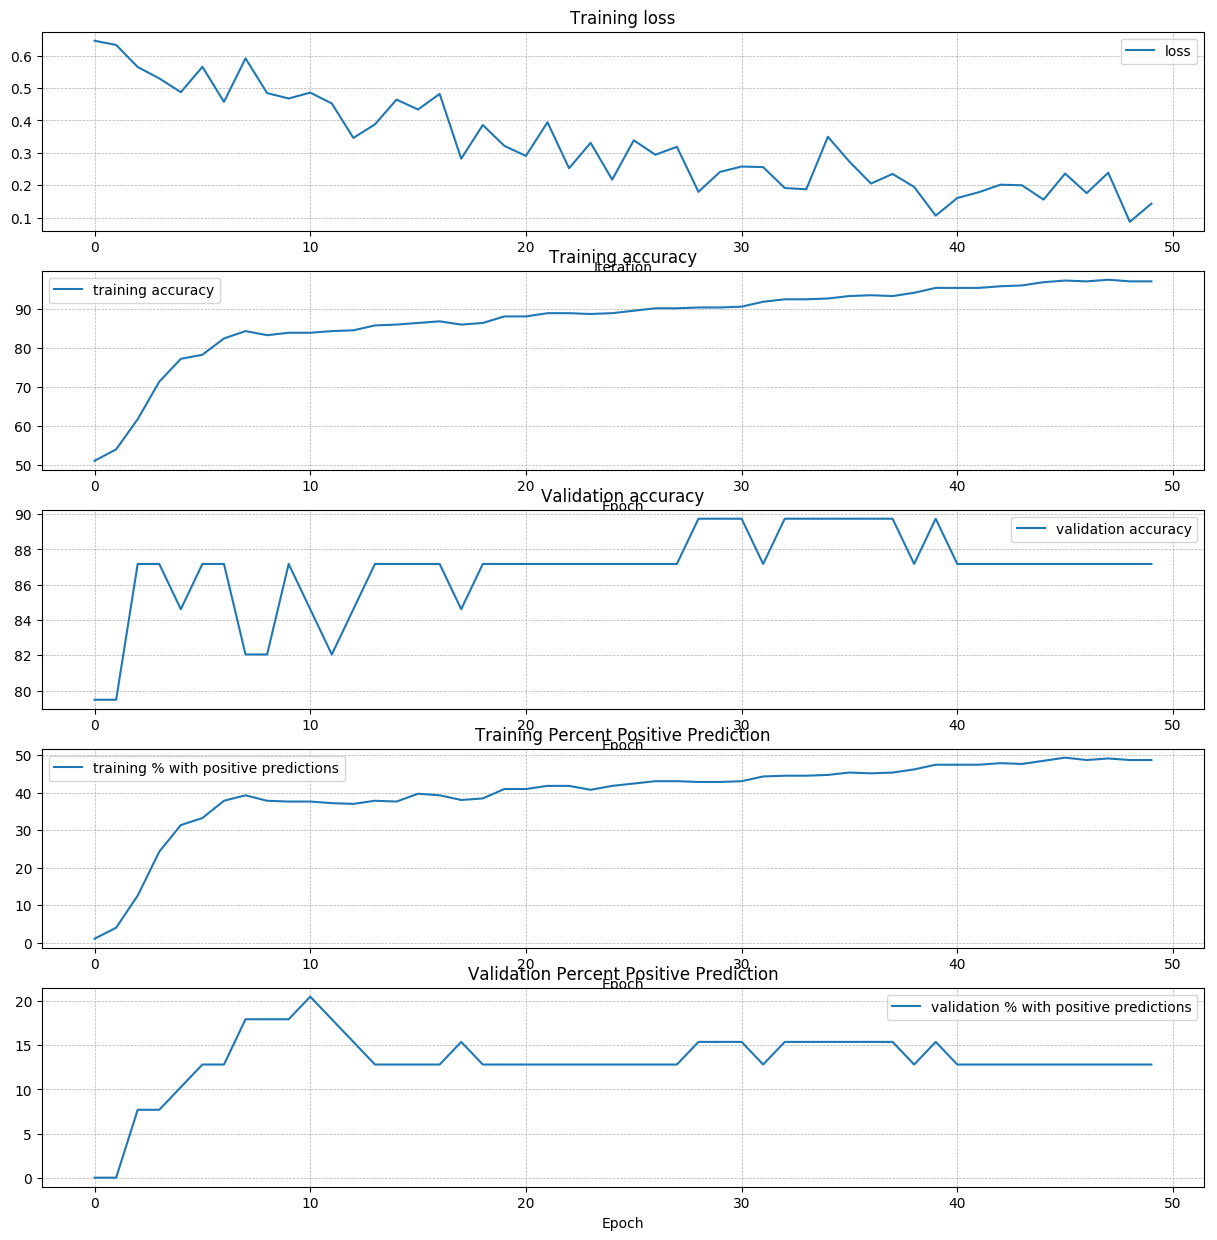

In [21]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized inputs, no oversampling

In [22]:
train = CustomDataset(dataframe=train_data)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data)
loader_test = DataLoader(test, batch_size=64)

In [23]:
input_size = 448
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=50)

Epoch 0, loss = 61.8483, train_acc = 67.3203, val_acc = 71.7949, train_pos = 21.8954, val_pos = 17.9487
Epoch 1, loss = 26.5776, train_acc = 75.4902, val_acc = 58.9744, train_pos = 13.7255, val_pos = 30.7692
Epoch 2, loss = 27.7501, train_acc = 66.0131, val_acc = 71.7949, train_pos = 30.3922, val_pos = 17.9487
Epoch 3, loss = 20.5433, train_acc = 73.8562, val_acc = 74.3590, train_pos = 16.0131, val_pos = 15.3846
Epoch 4, loss = 26.9409, train_acc = 72.8758, val_acc = 76.9231, train_pos = 20.2614, val_pos = 17.9487
Epoch 5, loss = 10.1352, train_acc = 74.1830, val_acc = 76.9231, train_pos = 15.6863, val_pos = 12.8205
Epoch 6, loss = 40.5822, train_acc = 69.2810, val_acc = 76.9231, train_pos = 29.0850, val_pos = 12.8205
Epoch 7, loss = 5.5447, train_acc = 77.7778, val_acc = 76.9231, train_pos = 15.3595, val_pos = 12.8205
Epoch 8, loss = 8.8533, train_acc = 72.5490, val_acc = 71.7949, train_pos = 27.1242, val_pos = 17.9487
Epoch 9, loss = 19.4526, train_acc = 78.1046, val_acc = 76.9231, t

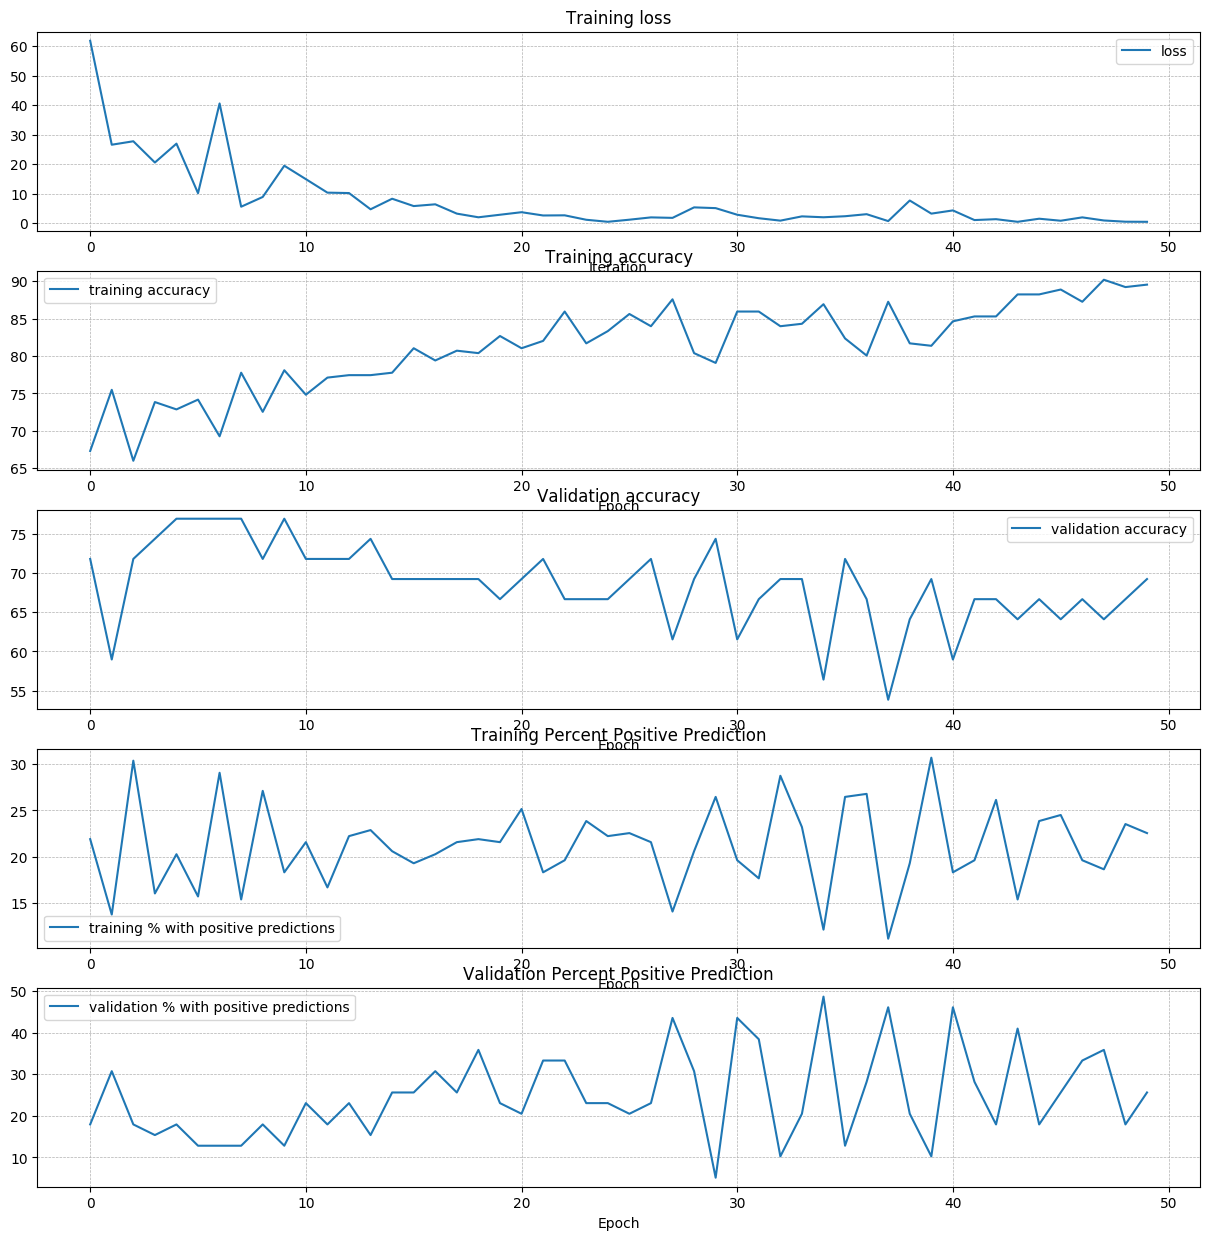

In [24]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with manually curated inputs, unnormalized

In [25]:
input_size = 38 
hidden_size = 20
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_m, loader_val_m, epochs=50)

Epoch 0, loss = 126.8658, train_acc = 22.8758, val_acc = 20.5128, train_pos = 99.6732, val_pos = 100.0000
Epoch 1, loss = 136.4194, train_acc = 22.8758, val_acc = 20.5128, train_pos = 99.6732, val_pos = 100.0000
Epoch 2, loss = 121.8742, train_acc = 22.8758, val_acc = 20.5128, train_pos = 99.6732, val_pos = 100.0000
Epoch 3, loss = 161.4470, train_acc = 22.8758, val_acc = 20.5128, train_pos = 99.6732, val_pos = 100.0000
Epoch 4, loss = 143.3398, train_acc = 22.8758, val_acc = 20.5128, train_pos = 99.6732, val_pos = 100.0000
Epoch 5, loss = 88.7295, train_acc = 22.8758, val_acc = 20.5128, train_pos = 99.6732, val_pos = 100.0000
Epoch 6, loss = 100.6959, train_acc = 22.8758, val_acc = 20.5128, train_pos = 99.6732, val_pos = 100.0000
Epoch 7, loss = 101.9763, train_acc = 22.8758, val_acc = 20.5128, train_pos = 99.6732, val_pos = 100.0000
Epoch 8, loss = 95.0151, train_acc = 22.8758, val_acc = 20.5128, train_pos = 99.6732, val_pos = 100.0000
Epoch 9, loss = 72.8664, train_acc = 22.8758, va

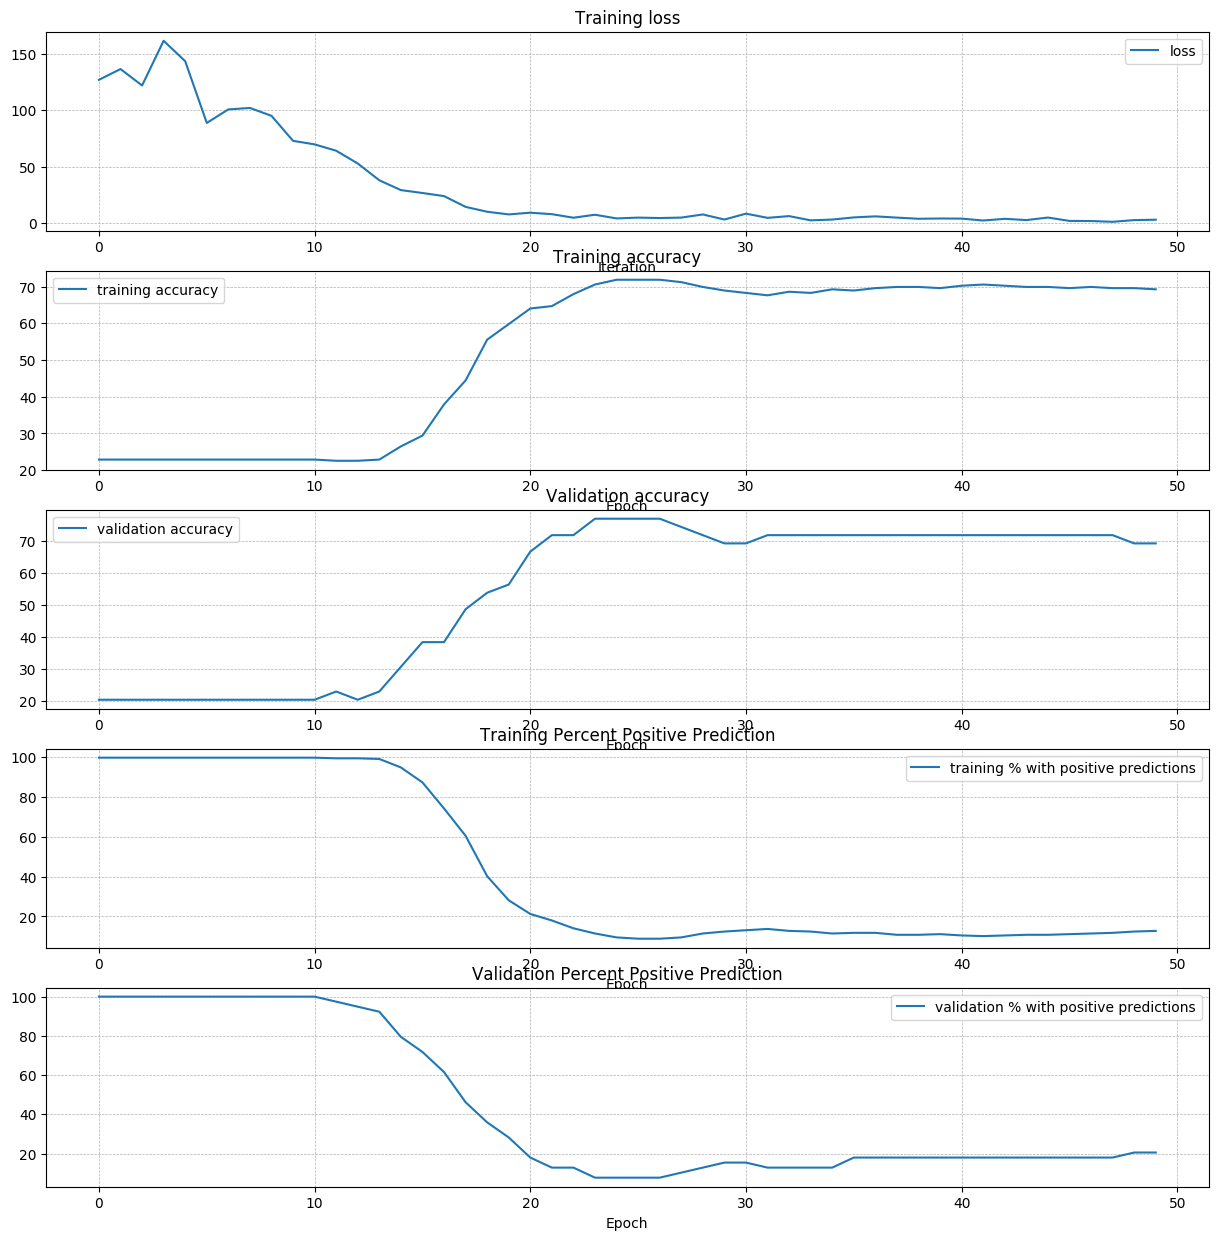

In [26]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with manually curated inputs, unnormalized, oversampled

In [27]:
train_manual = df_manual.iloc[:NUM_TRAIN+NUM_VAL]

index_0 = train_manual.index[train_manual['OA_check'] == 0.0].tolist()
class_0 = train_manual.loc[index_0]
index_1 = train_manual.index[train_manual['OA_check'] == 1.0].tolist()
class_1 = train_manual.loc[index_1]
class_count_0 = len(class_0)
class_1_over = class_1.sample(class_count_0, replace=True)
train_m_over = pd.concat([class_1_over, class_0], axis=0)
# shuffle the DataFrame rows
train_m_over = train_m_over.sample(frac = 1)

NUM_TRAIN_M_OS = len(train_m_over)

train_m = CustomDataset(dataframe=train_m_over)
loader_train_m = DataLoader(train_m, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN_M_OS)))

val_m = CustomDataset(dataframe=df_manual.iloc[:NUM_TRAIN+NUM_VAL])
loader_val_m = DataLoader(val_m, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TRAIN+NUM_VAL)))

test_m = CustomDataset(dataframe=df_manual.iloc[NUM_TRAIN+NUM_VAL:])
loader_test_m = DataLoader(test_m, batch_size=64)

input_size = 38 
hidden_size = 20
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_m, loader_val_m, epochs=200)

Epoch 0, loss = 19.6341, train_acc = 51.3060, val_acc = 35.8974, train_pos = 49.8134, val_pos = 74.3590
Epoch 1, loss = 17.1549, train_acc = 53.1716, val_acc = 48.7179, train_pos = 43.4701, val_pos = 46.1538
Epoch 2, loss = 6.7207, train_acc = 50.1866, val_acc = 38.4615, train_pos = 52.4254, val_pos = 71.7949
Epoch 3, loss = 7.1879, train_acc = 52.7985, val_acc = 58.9744, train_pos = 55.0373, val_pos = 30.7692
Epoch 4, loss = 8.7502, train_acc = 49.8134, val_acc = 38.4615, train_pos = 47.9478, val_pos = 71.7949
Epoch 5, loss = 1.5437, train_acc = 51.1194, val_acc = 48.7179, train_pos = 48.1343, val_pos = 41.0256
Epoch 6, loss = 4.0144, train_acc = 55.4104, val_acc = 61.5385, train_pos = 53.1716, val_pos = 28.2051
Epoch 7, loss = 5.0206, train_acc = 52.2388, val_acc = 61.5385, train_pos = 51.8657, val_pos = 28.2051
Epoch 8, loss = 3.3710, train_acc = 55.2239, val_acc = 66.6667, train_pos = 51.8657, val_pos = 23.0769
Epoch 9, loss = 7.4217, train_acc = 55.2239, val_acc = 66.6667, train_p

Epoch 80, loss = 0.7412, train_acc = 65.6716, val_acc = 69.2308, train_pos = 48.1343, val_pos = 15.3846
Epoch 81, loss = 1.0102, train_acc = 63.2463, val_acc = 69.2308, train_pos = 37.1269, val_pos = 46.1538
Epoch 82, loss = 0.9532, train_acc = 68.6567, val_acc = 69.2308, train_pos = 46.6418, val_pos = 15.3846
Epoch 83, loss = 1.0569, train_acc = 61.1940, val_acc = 69.2308, train_pos = 39.1791, val_pos = 46.1538
Epoch 84, loss = 0.6411, train_acc = 68.2836, val_acc = 69.2308, train_pos = 49.2537, val_pos = 30.7692
Epoch 85, loss = 0.9978, train_acc = 67.7239, val_acc = 76.9231, train_pos = 40.8582, val_pos = 2.5641
Epoch 86, loss = 0.5022, train_acc = 63.9925, val_acc = 69.2308, train_pos = 42.7239, val_pos = 15.3846
Epoch 87, loss = 0.8132, train_acc = 68.8433, val_acc = 69.2308, train_pos = 43.4701, val_pos = 15.3846
Epoch 88, loss = 0.8297, train_acc = 68.6567, val_acc = 69.2308, train_pos = 38.8060, val_pos = 35.8974
Epoch 89, loss = 0.6769, train_acc = 64.3657, val_acc = 79.4872, 

Epoch 160, loss = 1.4210, train_acc = 60.4478, val_acc = 69.2308, train_pos = 34.7015, val_pos = 35.8974
Epoch 161, loss = 0.7968, train_acc = 63.9925, val_acc = 71.7949, train_pos = 39.3657, val_pos = 17.9487
Epoch 162, loss = 0.9600, train_acc = 67.9104, val_acc = 76.9231, train_pos = 46.6418, val_pos = 2.5641
Epoch 163, loss = 0.4195, train_acc = 68.0970, val_acc = 64.1026, train_pos = 33.0224, val_pos = 51.2821
Epoch 164, loss = 0.8744, train_acc = 66.9776, val_acc = 66.6667, train_pos = 44.9627, val_pos = 12.8205
Epoch 165, loss = 0.7128, train_acc = 71.0821, val_acc = 74.3590, train_pos = 43.0970, val_pos = 5.1282
Epoch 166, loss = 0.6166, train_acc = 68.4701, val_acc = 76.9231, train_pos = 38.9925, val_pos = 2.5641
Epoch 167, loss = 0.7532, train_acc = 67.1642, val_acc = 69.2308, train_pos = 36.5672, val_pos = 10.2564
Epoch 168, loss = 0.7975, train_acc = 65.8582, val_acc = 69.2308, train_pos = 33.7687, val_pos = 46.1538
Epoch 169, loss = 0.6243, train_acc = 64.1791, val_acc = 6

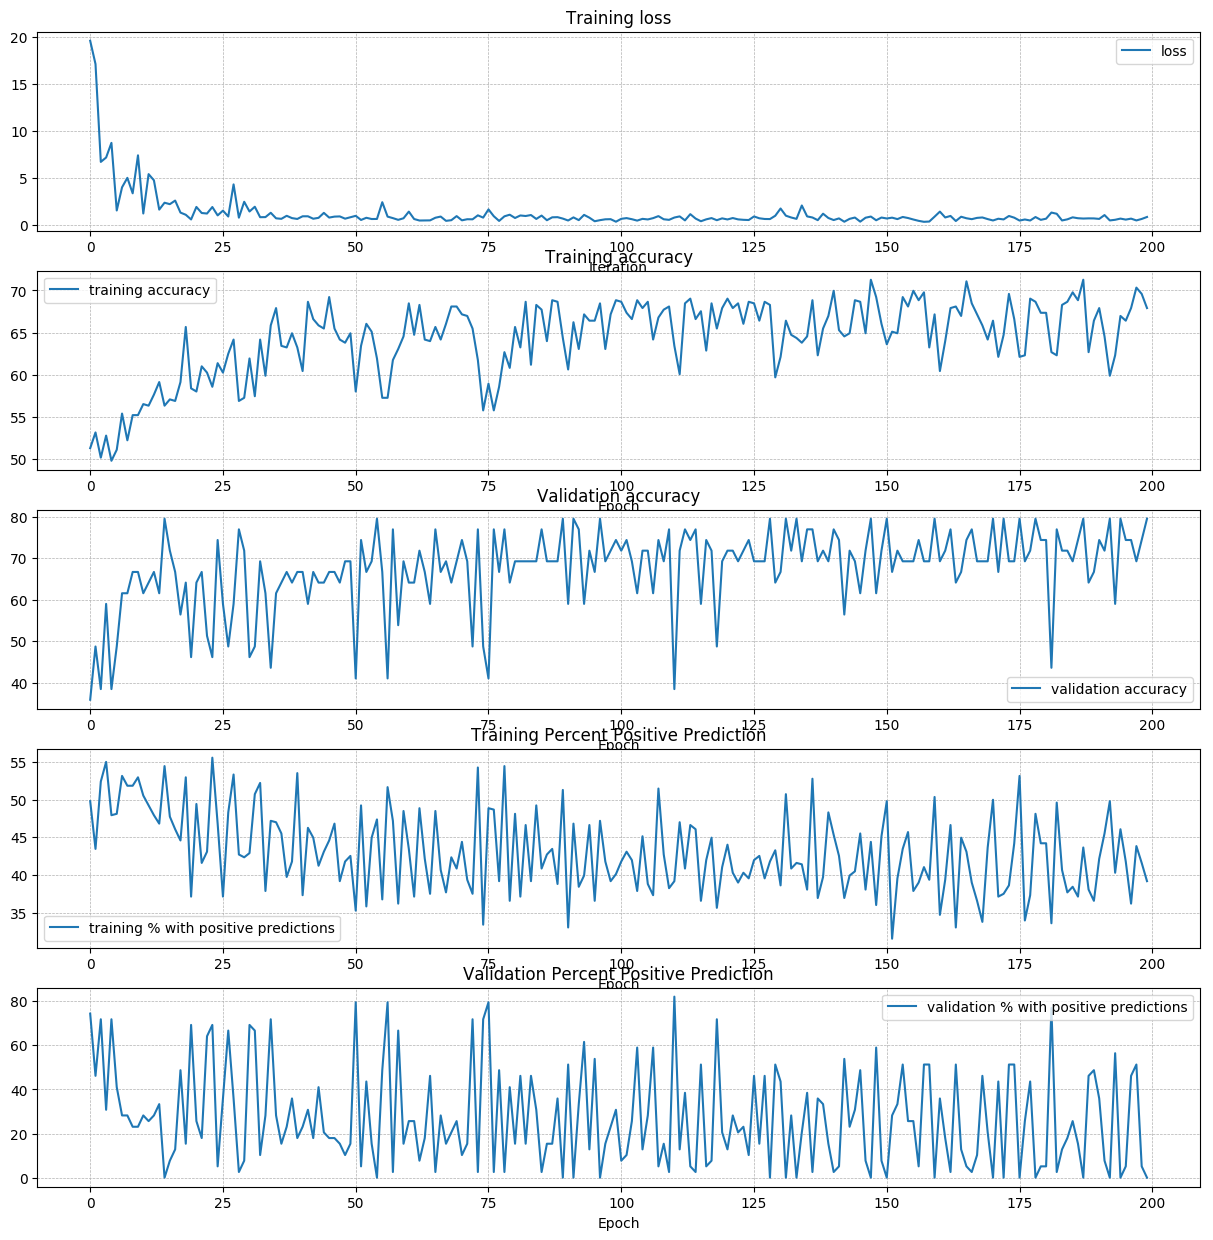

In [28]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized inputs, no oversampling, weighted loss

In [29]:
# use weighted loss instead of oversampling 
train = CustomDataset(dataframe=train_data)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data)
loader_test = DataLoader(test, batch_size=64)

input_size = 448
hidden_size = 20
num_classes = 1

num_samples_pos = train_data[train_data['OA_check']==1].shape[0]
num_samples_neg = train_data[train_data['OA_check']==0].shape[0]
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=50, \
    use_BCE_weight=True, num_samples_pos=num_samples_pos, num_samples_neg=num_samples_neg)

Epoch 0, loss = 396.0020, train_acc = 25.1634, val_acc = 23.0769, train_pos = 96.7320, val_pos = 87.1795
Epoch 1, loss = 137.4908, train_acc = 29.7386, val_acc = 41.0256, train_pos = 90.8497, val_pos = 69.2308
Epoch 2, loss = 109.0960, train_acc = 42.1569, val_acc = 61.5385, train_pos = 71.2418, val_pos = 33.3333
Epoch 3, loss = 145.8165, train_acc = 60.7843, val_acc = 69.2308, train_pos = 38.2353, val_pos = 20.5128
Epoch 4, loss = 154.7922, train_acc = 68.3007, val_acc = 71.7949, train_pos = 24.8366, val_pos = 17.9487
Epoch 5, loss = 114.4477, train_acc = 69.6078, val_acc = 69.2308, train_pos = 23.5294, val_pos = 20.5128
Epoch 6, loss = 98.6153, train_acc = 67.9739, val_acc = 69.2308, train_pos = 28.4314, val_pos = 25.6410
Epoch 7, loss = 88.0400, train_acc = 65.3595, val_acc = 61.5385, train_pos = 33.6601, val_pos = 33.3333
Epoch 8, loss = 34.9404, train_acc = 62.0915, val_acc = 56.4103, train_pos = 39.5425, val_pos = 38.4615
Epoch 9, loss = 78.8184, train_acc = 61.7647, val_acc = 56

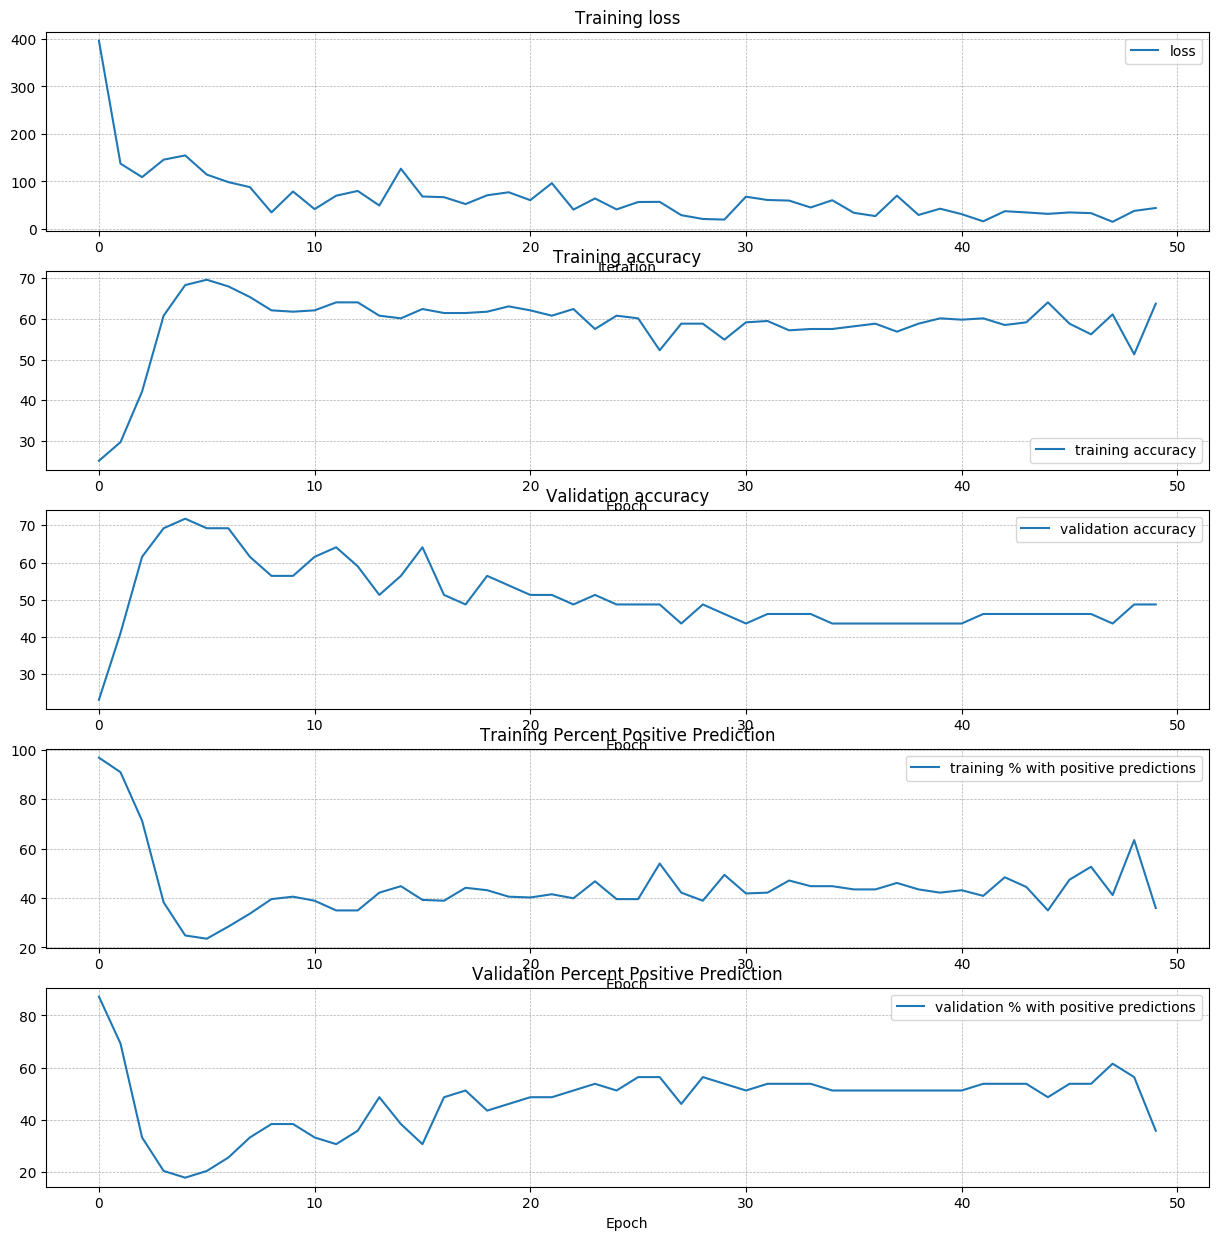

In [30]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()